# Complete Validation and Diagnostic Tests

This notebook provides a **comprehensive guide to validation and diagnostic testing** for panel data models.

## What You'll Learn

- ✅ 20+ validation tests for panel data
- ✅ Specification tests (Hausman, RESET, Mundlak, Chow)
- ✅ Diagnostic tests (serial correlation, heteroskedasticity, cross-sectional dependence)
- ✅ Unit root tests (LLC, IPS, Fisher)
- ✅ Cointegration tests (Pedroni, Kao)
- ✅ ValidationSuite (run all tests at once)
- ✅ Interpretation and remediation strategies

## Table of Contents

1. [Introduction to Validation](#introduction)
2. [Setup and Data](#setup)
3. [Specification Tests](#specification-tests)
4. [Diagnostic Tests](#diagnostic-tests)
5. [Unit Root Tests](#unit-root)
6. [Cointegration Tests](#cointegration)
7. [ValidationSuite](#validation-suite)
8. [Remediation Guide](#remediation)

---

## 1. Introduction to Validation {#introduction}

### Why Validate?

**Model validation** is critical for reliable inference:
- Ensures assumptions are satisfied
- Detects specification errors
- Guides model improvements
- Increases credibility of results

### Types of Tests

| Category | Purpose | Examples |
|----------|---------|----------|
| **Specification** | Model form correct? | Hausman, RESET, Mundlak |
| **Diagnostics** | Assumptions satisfied? | Serial correlation, heteroskedasticity |
| **Stationarity** | Data properties | Unit root tests |
| **Long-run** | Cointegration | Pedroni, Kao |

### The Validation Workflow

```
1. Estimate model
   ↓
2. Run specification tests
   ↓
3. Run diagnostic tests
   ↓
4. Check for violations
   ↓
5. Apply remediation if needed
   ↓
6. Re-estimate and re-test
```

Let's start!

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import panelbox as pb

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
np.random.seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"PanelBox version: {pb.__version__}")
print("Validation toolkit ready!")

PanelBox version: 0.8.0
Validation toolkit ready!


---

## 2. Setup and Data {#setup}

We'll use the **Grunfeld dataset** for demonstration.

In [2]:
# Load data
data = pb.load_grunfeld()

print("Dataset loaded:")
print(f"Shape: {data.shape}")
print(f"Variables: {list(data.columns)}")
print(f"\nFirst rows:")
data.head()

Dataset loaded:
Shape: (200, 5)
Variables: ['firm', 'year', 'invest', 'value', 'capital']

First rows:


,firm,year,invest,value,capital
0,1,1935,317.6,3078.5,2.8
1,1,1936,391.8,4661.7,52.6
2,1,1937,410.6,5387.1,156.9
3,1,1938,257.7,2792.2,209.2
4,1,1939,330.8,4313.2,203.4


### Estimate Baseline Models

We'll test these models:

In [3]:
# Fixed Effects model
fe = pb.FixedEffects(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)
fe_results = fe.fit()

print("Fixed Effects Model Estimated")
print("="*60)
print(fe_results.summary())

Fixed Effects Model Estimated
                       Fixed Effects Estimation Results                       
Formula: invest ~ value + capital
Model:   Fixed Effects
------------------------------------------------------------------------------
No. Observations:                 200
No. Entities:                      10
No. Time Periods:                  20
Degrees of Freedom:               188
R-squared:                     0.7899
Adj. R-squared:                0.7776
R-squared (within):            0.7899
R-squared (between):           1.0000
R-squared (overall):           0.9496
Standard Errors:            nonrobust
F-statistic (FE vs OLS):      58.2744
F-test p-value:                0.0000
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
value                0.1066      0.0113   9.401  0.0000    0.0842    0.1289 ***
capital              0.3444      0.0178  19.397  0.0000   

In [4]:
# Random Effects model
re = pb.RandomEffects(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)
re_results = re.fit()

print("\nRandom Effects Model Estimated")
print("="*60)


Random Effects Model Estimated


---

## 3. Specification Tests {#specification-tests}

Specification tests check if the **model form is correct**.

### 3.1 Hausman Test (FE vs RE)

**H₀**: Random effects is consistent (no correlation between effects and regressors)

**H₁**: Fixed effects is consistent, random effects is not

**Rule**: If p < 0.05 → Use Fixed Effects

In [5]:
# Hausman test
hausman_test = pb.HausmanTest(fe_results, re_results)
hausman = hausman_test.run()

print("HAUSMAN TEST")
print("="*60)
print(hausman)
print(f"\nStatistic: {hausman.statistic:.4f}")
print(f"P-value: {hausman.pvalue:.4f}")
print(f"\nDecision: ", end="")
if hausman.pvalue < 0.05:
    print("✗ Reject H₀ → Use Fixed Effects")
    print("   (Random effects assumption violated)")
else:
    print("✓ Fail to reject H₀ → Can use Random Effects")
    print("   (RE is consistent and more efficient)")

HAUSMAN TEST
HAUSMAN SPECIFICATION TEST

H0: Random Effects is consistent (and efficient)
H1: Random Effects is inconsistent (use Fixed Effects)

----------------------------------------------------------------------
Test Statistic (Chi2)                  -4.8601
P-value                                 1.0000
Degrees of Freedom                           2
----------------------------------------------------------------------

Conclusion: Fail to reject H0 at 5% level. Random Effects is consistent and efficient.
Recommendation: Random Effects

COEFFICIENT COMPARISON
Variable        Fixed Effects   Random Effects  Difference     
----------------------------------------------------------------------
capital                 0.3444         0.3444         0.0000
value                   0.1066         0.1006         0.0060


Statistic: -4.8601
P-value: 1.0000

Decision: ✓ Fail to reject H₀ → Can use Random Effects
   (RE is consistent and more efficient)


### 3.2 RESET Test (Functional Form)

**Ramsey RESET test** checks for specification errors in functional form.

**H₀**: Model is correctly specified

**H₁**: Model has specification errors (missing variables, wrong functional form)

In [6]:
# RESET test
reset_test = pb.RESETTest(fe_results)
reset_result = reset_test.run()

print("\nRESET TEST (Ramsey)")
print("="*60)
print(reset_result)
print(f"\nStatistic: {reset_result.statistic:.4f}")
print(f"P-value: {reset_result.pvalue:.4f}")
print(f"\nDecision: ", end="")
if reset_result.pvalue < 0.05:
    print("✗ Reject H₀ → Specification error detected")
    print("   Consider: non-linear terms, interactions, omitted variables")
else:
    print("✓ Fail to reject H₀ → Functional form appears correct")


RESET TEST (Ramsey)
RESET TEST FOR SPECIFICATION

H0: Model is correctly specified (linear functional form)
H1: Nonlinear terms needed (specification error)

----------------------------------------------------------------------
Test Statistic                        280.1759
P-value                                 0.0000
Degrees of Freedom                    (2, 195)
----------------------------------------------------------------------

Conclusion: Reject H0 at 5% level. Nonlinear terms needed (specification error)

Additional Information:
  powers: [2, 3]
  gamma_coefficients: {'fitted_pow2': 0.002020553365177356, 'fitted_pow3': -9.589224051788359e-07}
  standard_errors: {'fitted_pow2': 0.000555379626758895, 'fitted_pow3': 4.26899418881705e-07}
  wald_statistic: 560.3518
  F_statistic: 280.1759
  df_numerator: 2
  df_denominator: 195
  pvalue_chi2: 0.0000
  augmented_formula: invest ~ value + capital + fitted_pow2 + fitted_pow3
  df: (2, 195)


Statistic: 280.1759
P-value: 0.0000

D

### 3.3 Mundlak Test (RE Specification)

**Mundlak test** checks if random effects specification is appropriate.

**H₀**: Random effects specification is correct

**H₁**: Correlated random effects (need FE or include group means)

In [7]:
# Mundlak test
mundlak_test = pb.MundlakTest(re_results)
mundlak = mundlak_test.run()

print("\nMUNDLAK TEST")
print("="*60)
print(mundlak)
print(f"\nStatistic: {mundlak.statistic:.4f}")
print(f"P-value: {mundlak.pvalue:.4f}")
print(f"\nDecision: ", end="")
if mundlak.pvalue < 0.05:
    print("✗ Reject H₀ → Use Fixed Effects or correlated RE")
else:
    print("✓ Fail to reject H₀ → RE specification OK")


MUNDLAK TEST
MUNDLAK TEST FOR RE SPECIFICATION

H0: RE is consistent (entity effects uncorrelated with regressors)
H1: RE is inconsistent (use Fixed Effects)

----------------------------------------------------------------------
Test Statistic                         10.0096
P-value                                 0.0067
Degrees of Freedom                           2
----------------------------------------------------------------------

Conclusion: Reject H0 at 5% level. RE is inconsistent (use Fixed Effects)

Additional Information:
  n_time_varying_vars: 2
  delta_coefficients: {'value_mean': 0.20572921484296608, 'capital_mean': -1.537718005964002}
  standard_errors: {'value_mean': 0.08264600962170353, 'capital_mean': 0.5402537831382738}
  F_statistic: 5.0048
  augmented_formula: invest ~ value + capital + value_mean + capital_mean
  implementation: Pooled OLS with cluster-robust SE (entity-clustered)
  df: 2


Statistic: 10.0096
P-value: 0.0067

Decision: ✗ Reject H₀ → Use Fixed 

### 3.4 Chow Test (Structural Break)

**Chow test** detects structural breaks in the panel.

**H₀**: No structural break

**H₁**: Structural break exists

In [8]:
# Chow test (test break at year 1945 - middle of sample)
chow_test = pb.ChowTest(fe_results)
chow = chow_test.run(break_point=1945)

print("\nCHOW TEST (Structural Break)")
print("="*60)
print(f"Break point: 1945")
print(f"Statistic: {chow.statistic:.4f}")
print(f"P-value: {chow.pvalue:.4f}")
print(f"\nDecision: ", end="")
if chow.pvalue < 0.05:
    print("✗ Reject H₀ → Structural break detected")
    print("   Consider: split sample, interaction with time dummy")
else:
    print("✓ Fail to reject H₀ → No structural break")


CHOW TEST (Structural Break)
Break point: 1945
Statistic: 3.6657
P-value: 0.0133

Decision: ✗ Reject H₀ → Structural break detected
   Consider: split sample, interaction with time dummy


---

## 4. Diagnostic Tests {#diagnostic-tests}

Diagnostic tests check if model **assumptions are satisfied**.

### 4.1 Serial Correlation Tests

Serial correlation violates the assumption $\mathbb{E}[\varepsilon_{it}\varepsilon_{is}] = 0$ for $t \neq s$.

#### Wooldridge AR Test

**H₀**: No first-order serial correlation

Most commonly used test for panel data.

In [9]:
# Wooldridge test
wooldridge_test = pb.WooldridgeARTest(fe_results)
wooldridge = wooldridge_test.run()

print("WOOLDRIDGE AR TEST")
print("="*60)
print(wooldridge)
print(f"\nStatistic: {wooldridge.statistic:.4f}")
print(f"P-value: {wooldridge.pvalue:.4f}")
print(f"\nDecision: ", end="")
if wooldridge.pvalue < 0.05:
    print("✗ Reject H₀ → Serial correlation detected")
    print("   Remedy: Use robust SE (Driscoll-Kraay or Newey-West)")
else:
    print("✓ Fail to reject H₀ → No serial correlation")

WOOLDRIDGE AR TEST
WOOLDRIDGE TEST FOR AUTOCORRELATION

H0: No first-order autocorrelation
H1: First-order autocorrelation present

----------------------------------------------------------------------
Test Statistic                         54.9087
P-value                                 0.0000
Degrees of Freedom                      (1, 9)
----------------------------------------------------------------------

Conclusion: Reject H0 at 5% level. First-order autocorrelation present

Additional Information:
  coefficient: 0.0739
  std_error: 0.0775
  t_statistic: 7.4100
  n_entities: 10
  n_obs_used: 180
  df: (1, 9)


Statistic: 54.9087
P-value: 0.0000

Decision: ✗ Reject H₀ → Serial correlation detected
   Remedy: Use robust SE (Driscoll-Kraay or Newey-West)


#### Breusch-Godfrey Test

**H₀**: No serial correlation up to order p

In [10]:
# Breusch-Godfrey test
bg_test = pb.BreuschGodfreyTest(fe_results)
bg = bg_test.run(lags=2)

print("\nBREUSCH-GODFREY TEST")
print("="*60)
print(f"Statistic: {bg.statistic:.4f}")
print(f"P-value: {bg.pvalue:.4f}")
print(f"\nDecision: ", end="")
if bg.pvalue < 0.05:
    print("✗ Serial correlation detected")
else:
    print("✓ No serial correlation")


BREUSCH-GODFREY TEST
Statistic: 4.3970
P-value: 0.1110

Decision: ✓ No serial correlation


#### Baltagi-Wu Test

**H₀**: No first-order serial correlation

Based on Durbin-Watson for panels.

In [11]:
# Baltagi-Wu test
bw_test = pb.BaltagiWuTest(fe_results)
bw = bw_test.run()

print("\nBALTAGI-WU TEST")
print("="*60)
lbi_stat = bw.metadata.get("lbi_statistic", 0)
print(f"LBI Statistic: {lbi_stat:.4f}")
print(f"P-value: {bw.pvalue:.4f}")
print(f"Critical value (expected under H0): ~2.0")
print(f"\nInterpretation: ", end="")
if lbi_stat < 1.5:
    print("Strong positive serial correlation")
elif lbi_stat > 2.5:
    print("Negative serial correlation")
else:
    print("No strong evidence of serial correlation")


BALTAGI-WU TEST
LBI Statistic: 0.7173
P-value: 0.0041
Critical value (expected under H0): ~2.0

Interpretation: Strong positive serial correlation


### 4.2 Heteroskedasticity Tests

Heteroskedasticity violates $\mathbb{E}[\varepsilon_{it}^2] = \sigma^2$ (constant variance).

#### Modified Wald Test

**H₀**: Homoskedastic errors (constant variance across entities)

Most commonly used for panel data.

In [12]:
# Modified Wald test
mwald_test = pb.ModifiedWaldTest(fe_results)
mwald = mwald_test.run()

print("MODIFIED WALD TEST")
print("="*60)
print(mwald)
print(f"\nStatistic: {mwald.statistic:.4f}")
print(f"P-value: {mwald.pvalue:.4f}")
print(f"\nDecision: ", end="")
if mwald.pvalue < 0.05:
    print("✗ Reject H₀ → Heteroskedasticity detected")
    print("   Remedy: Use robust SE (HC0-HC3, clustered)")
else:
    print("✓ Fail to reject H₀ → Homoskedastic errors")

MODIFIED WALD TEST
MODIFIED WALD TEST FOR GROUPWISE HETEROSKEDASTICITY

H0: Homoskedasticity (constant variance across entities)
H1: Groupwise heteroskedasticity present

----------------------------------------------------------------------
Test Statistic                        215.6715
P-value                                 0.0000
Degrees of Freedom                          10
----------------------------------------------------------------------

Conclusion: Reject H0 at 5% level. Groupwise heteroskedasticity present

Additional Information:
  n_entities: 10
  pooled_variance: 2489.9639
  min_entity_var: 150.2636
  max_entity_var: 9090.5217
  variance_ratio: 60.4972
  df: 10


Statistic: 215.6715
P-value: 0.0000

Decision: ✗ Reject H₀ → Heteroskedasticity detected
   Remedy: Use robust SE (HC0-HC3, clustered)


#### Breusch-Pagan Test

**H₀**: Homoskedasticity

In [13]:
# Breusch-Pagan test
bp_test = pb.BreuschPaganTest(fe_results)
bp = bp_test.run()

print("\nBREUSCH-PAGAN TEST")
print("="*60)
print(f"Statistic: {bp.statistic:.4f}")
print(f"P-value: {bp.pvalue:.4f}")
print(f"\nDecision: ", end="")
if bp.pvalue < 0.05:
    print("✗ Heteroskedasticity detected")
else:
    print("✓ Homoskedasticity")


BREUSCH-PAGAN TEST
Statistic: 61.8247
P-value: 0.0000

Decision: ✗ Heteroskedasticity detected


#### White Test

**H₀**: Homoskedasticity (more general than BP)

In [14]:
# White test
white_test = pb.WhiteTest(fe_results)
white = white_test.run()

print("\nWHITE TEST")
print("="*60)
print(f"Statistic: {white.statistic:.4f}")
print(f"P-value: {white.pvalue:.4f}")
print(f"\nDecision: ", end="")
if white.pvalue < 0.05:
    print("✗ Heteroskedasticity detected")
else:
    print("✓ Homoskedasticity")


WHITE TEST
Statistic: 78.1516
P-value: 0.0000

Decision: ✗ Heteroskedasticity detected


### 4.3 Cross-Sectional Dependence Tests

Cross-sectional dependence: $\mathbb{E}[\varepsilon_{it}\varepsilon_{jt}] \neq 0$ for $i \neq j$

Common in macro panels (countries, regions).

#### Pesaran CD Test

**H₀**: No cross-sectional dependence

Most powerful test, works for large T.

In [15]:
# Pesaran CD test
cd_test = pb.PesaranCDTest(fe_results)
cd = cd_test.run()

print("PESARAN CD TEST")
print("="*60)
print(cd)
print(f"\nStatistic: {cd.statistic:.4f}")
print(f"P-value: {cd.pvalue:.4f}")
print(f"\nDecision: ", end="")
if cd.pvalue < 0.05:
    print("✗ Reject H₀ → Cross-sectional dependence detected")
    print("   Remedy: Use Driscoll-Kraay SE or spatial models")
else:
    print("✓ Fail to reject H₀ → No cross-sectional dependence")

PESARAN CD TEST
PESARAN CD TEST FOR CROSS-SECTIONAL DEPENDENCE

H0: No cross-sectional dependence
H1: Cross-sectional dependence present

----------------------------------------------------------------------
Test Statistic                          1.0992
P-value                                 0.2717
----------------------------------------------------------------------

Conclusion: Fail to reject H0 at 5% level. No cross-sectional dependence

Additional Information:
  n_entities: 10
  n_time_periods: 20
  n_pairs: 45
  avg_correlation: 0.0366
  avg_abs_correlation: 0.3791
  max_abs_correlation: 0.9019
  min_correlation: -0.5972
  max_correlation: 0.9019


Statistic: 1.0992
P-value: 0.2717

Decision: ✓ Fail to reject H₀ → No cross-sectional dependence


#### Breusch-Pagan LM Test

**H₀**: No cross-sectional dependence

Works for small T, large N.

In [16]:
# Breusch-Pagan LM test
bplm_test = pb.BreuschPaganLMTest(fe_results)
bplm = bplm_test.run()

print("\nBREUSCH-PAGAN LM TEST")
print("="*60)
print(f"Statistic: {bplm.statistic:.4f}")
print(f"P-value: {bplm.pvalue:.4f}")
print(f"\nDecision: ", end="")
if bplm.pvalue < 0.05:
    print("✗ Cross-sectional dependence detected")
else:
    print("✓ No cross-sectional dependence")


BREUSCH-PAGAN LM TEST
Statistic: 182.9637
P-value: 0.0000

Decision: ✗ Cross-sectional dependence detected


#### Frees Test

**H₀**: No cross-sectional dependence

Distribution-free test.

In [17]:
# Frees test
frees_test = pb.FreesTest(fe_results)
frees = frees_test.run()

print("\nFREES TEST")
print("="*60)
print(f"Statistic: {frees.statistic:.4f}")
critical_value = frees.metadata.get("critical_values", {}).get("alpha_0.05", 0)
print(f"Critical value (5%): {critical_value:.4f}")
q_frees = frees.metadata.get("q_frees_statistic", 0)
print(f"\nDecision: ", end="")
if q_frees > critical_value:
    print("✗ Cross-sectional dependence detected")
else:
    print("✓ No cross-sectional dependence")


FREES TEST
Statistic: 11.3239
Critical value (5%): 0.1100

Decision: ✗ Cross-sectional dependence detected


---

## 5. Unit Root Tests {#unit-root}

Unit root tests check if variables are **stationary** (constant mean/variance over time).

**Why it matters**: Non-stationary variables can lead to spurious regressions!

### 5.1 LLC Test (Levin-Lin-Chu)

**H₀**: All panels contain a unit root (non-stationary)

**H₁**: All panels are stationary

**Assumption**: Homogeneous autoregressive coefficient (restrictive)

In [18]:
# LLC test for 'value'
llc_value_test = pb.LLCTest(data, variable='value', entity_col='firm', time_col='year')
llc_value = llc_value_test.run()

print("LLC TEST - Value")
print("="*60)
print(llc_value)
print(f"\nStatistic: {llc_value.statistic:.4f}")
print(f"P-value: {llc_value.pvalue:.4f}")
print(f"\nDecision: ", end="")
if llc_value.pvalue < 0.05:
    print("✓ Reject H₀ → Variable is stationary")
else:
    print("✗ Fail to reject H₀ → Unit root present (non-stationary)")
    print("   Consider: first-differencing or cointegration")

LLC TEST - Value
Levin-Lin-Chu Panel Unit Root Test
Test statistic:    -3.4813
P-value:           0.0002
Lags:              0
Observations:      190
Cross-sections:    10
Deterministics:    Constant

H0: All panels contain unit roots
H1: All panels are stationary

Conclusion: Reject H0: Evidence against unit root (panels are stationary)

Statistic: -3.4813
P-value: 0.0002

Decision: ✓ Reject H₀ → Variable is stationary


### 5.2 IPS Test (Im-Pesaran-Shin)

**H₀**: All panels contain a unit root

**H₁**: Some panels are stationary (at least one)

**Advantage**: Allows heterogeneous autoregressive coefficients (more flexible)

In [19]:
# IPS test for 'value'
ips_value_test = pb.IPSTest(data, variable='value', entity_col='firm', time_col='year')
ips_value = ips_value_test.run()

print("\nIPS TEST - Value")
print("="*60)
print(ips_value)
print(f"\nStatistic: {ips_value.statistic:.4f}")
print(f"P-value: {ips_value.pvalue:.4f}")
print(f"\nDecision: ", end="")
if ips_value.pvalue < 0.05:
    print("✓ Reject H₀ → At least some panels stationary")
else:
    print("✗ Unit root in all panels")


IPS TEST - Value
Im-Pesaran-Shin Panel Unit Root Test
W-statistic:       3.2554
t-bar statistic:   -0.6035
P-value:           0.9994
Lags:              5
Observations:      140
Cross-sections:    10
Deterministics:    Constant

H0: All panels contain unit roots
H1: Some panels are stationary

Conclusion: Fail to reject H0: Evidence of unit root

Statistic: 3.2554
P-value: 0.9994

Decision: ✗ Unit root in all panels


### 5.3 Fisher Test

**H₀**: All panels contain a unit root

**H₁**: At least one panel is stationary

**Method**: Combines p-values from individual ADF tests

In [20]:
# Fisher test for 'value'
fisher_value_test = pb.FisherTest(data, variable='value', entity_col='firm', time_col='year')
fisher_value = fisher_value_test.run()

print("\nFISHER TEST - Value")
print("="*60)
print(fisher_value)
print(f"\nStatistic: {fisher_value.statistic:.4f}")
print(f"P-value: {fisher_value.pvalue:.4f}")
print(f"\nDecision: ", end="")
if fisher_value.pvalue < 0.05:
    print("✓ Reject H₀ → Evidence of stationarity")
else:
    print("✗ Unit root present")


FISHER TEST - Value
Fisher-type Panel Unit Root Test
Test type:         ADF
Fisher statistic:     11.1381
P-value:               0.9426

Cross-sections:    10
Trend:             c

H0: All series have unit roots
H1: At least one series is stationary

Conclusion: Fail to reject H0 at 5.0% level: Evidence of unit root

Statistic: 11.1381
P-value: 0.9426

Decision: ✗ Unit root present


### Unit Root Summary

Compare all three tests:

In [21]:
# Summary table
unit_root_summary = pd.DataFrame({
    'Test': ['LLC', 'IPS', 'Fisher'],
    'Statistic': [llc_value.statistic, ips_value.statistic, fisher_value.statistic],
    'P-value': [llc_value.pvalue, ips_value.pvalue, fisher_value.pvalue],
    'Decision': [
        'Stationary' if llc_value.pvalue < 0.05 else 'Unit Root',
        'Stationary' if ips_value.pvalue < 0.05 else 'Unit Root',
        'Stationary' if fisher_value.pvalue < 0.05 else 'Unit Root'
    ]
})

print("\nUNIT ROOT TEST SUMMARY - Value Variable")
print("="*60)
print(unit_root_summary.to_string(index=False))
print("\nRecommendation:")
print("- If all tests reject → Variable is stationary ✓")
print("- If all tests fail to reject → Variable has unit root")
print("- If mixed results → Check with additional lags or transformations")


UNIT ROOT TEST SUMMARY - Value Variable
  Test  Statistic  P-value   Decision
   LLC    -3.4813   0.0002 Stationary
   IPS     3.2554   0.9994  Unit Root
Fisher    11.1381   0.9426  Unit Root

Recommendation:
- If all tests reject → Variable is stationary ✓
- If all tests fail to reject → Variable has unit root
- If mixed results → Check with additional lags or transformations


---

## 6. Cointegration Tests {#cointegration}

**Cointegration**: Long-run equilibrium relationship between non-stationary variables.

If $y$ and $x$ are I(1) but $y - \beta x$ is I(0), they are **cointegrated**.

### 6.1 Pedroni Test

**H₀**: No cointegration

**H₁**: Cointegration exists

Provides 7 different test statistics.

In [22]:
# Pedroni test
pedroni_test = pb.PedroniTest(data, dependent='invest', independents=['value', 'capital'], 
                               entity_col='firm', time_col='year')
pedroni = pedroni_test.run()

print("PEDRONI COINTEGRATION TEST")
print("="*60)
print(pedroni)
print("\nPanel statistics (within-dimension):")
print(f"  Panel v-stat: {pedroni.panel_v:.4f}")
print(f"  Panel rho-stat: {pedroni.panel_rho:.4f}")
print(f"  Panel PP-stat: {pedroni.panel_pp:.4f}")
print(f"  Panel ADF-stat: {pedroni.panel_adf:.4f}")
print("\nGroup statistics (between-dimension):")
print(f"  Group rho-stat: {pedroni.group_rho:.4f}")
print(f"  Group PP-stat: {pedroni.group_pp:.4f}")
print(f"  Group ADF-stat: {pedroni.group_adf:.4f}")
print("\nDecision: If majority of tests reject H₀ → Cointegration exists")

PEDRONI COINTEGRATION TEST
Pedroni Panel Cointegration Tests

Within-dimension (Panel statistics):
  Panel v-statistic:       3687.3353  (p = 0.0000)
  Panel rho-statistic:       -0.5111  (p = 0.3046)
  Panel PP-statistic:        -6.7996  (p = 0.0000)
  Panel ADF-statistic:       -7.8238  (p = 0.0000)

Between-dimension (Group statistics):
  Group rho-statistic:       -0.6723  (p = 0.2507)
  Group PP-statistic:        -2.4172  (p = 0.0078)
  Group ADF-statistic:       -3.1045  (p = 0.0010)

Observations:      200
Cross-sections:    10
Trend:             Constant

H0: No cointegration
H1: Cointegration exists

Conclusion: Reject H0 (5/7 tests): Evidence of cointegration

Panel statistics (within-dimension):
  Panel v-stat: 3687.3353
  Panel rho-stat: -0.5111
  Panel PP-stat: -6.7996
  Panel ADF-stat: -7.8238

Group statistics (between-dimension):
  Group rho-stat: -0.6723
  Group PP-stat: -2.4172
  Group ADF-stat: -3.1045

Decision: If majority of tests reject H₀ → Cointegration exists


### 6.2 Kao Test

**H₀**: No cointegration

**H₁**: Cointegration exists

Simpler than Pedroni, single test statistic.

In [23]:
# Kao test
kao_test = pb.KaoTest(data, dependent='invest', independents=['value', 'capital'],
                      entity_col='firm', time_col='year')
kao = kao_test.run()

print("\nKAO COINTEGRATION TEST")
print("="*60)
print(kao)
print(f"\nStatistic: {kao.statistic:.4f}")
print(f"P-value: {kao.pvalue:.4f}")
print(f"\nDecision: ", end="")
if kao.pvalue < 0.05:
    print("✓ Reject H₀ → Cointegration exists")
    print("   Long-run relationship is valid")
else:
    print("✗ Fail to reject H₀ → No cointegration")
    print("   Spurious regression risk if variables are I(1)")


KAO COINTEGRATION TEST


Kao Panel Cointegration Test
ADF statistic:     2.8494
P-value:           0.9978
Observations:      200
Cross-sections:    10
Trend:             Constant

H0: No cointegration
H1: Cointegration exists

Conclusion: Fail to reject H0: No evidence of cointegration

Statistic: 2.8494
P-value: 0.9978

Decision: ✗ Fail to reject H₀ → No cointegration
   Spurious regression risk if variables are I(1)


---

## 7. ValidationSuite - Run All Tests at Once {#validation-suite}

**ValidationSuite** runs all relevant tests and creates a comprehensive report.

In [24]:
# Create validation suite
from panelbox.validation.validation_suite import ValidationSuite
suite = ValidationSuite(fe_results)

# Run all tests
report = suite.run(tests='default')

print("VALIDATION SUITE - COMPREHENSIVE REPORT")
print("="*70)
print(report)

VALIDATION SUITE - COMPREHENSIVE REPORT
MODEL VALIDATION REPORT

Model Information:
  Type:    Fixed Effects
  Formula: invest ~ value + capital
  N obs:   200
  N entities: 10

VALIDATION TESTS SUMMARY
Test                                Statistic    P-value    Result    
------------------------------------------------------------------------------

Serial Correlation Tests:
  Wooldridge                        54.909       0.0000     REJECT    
  Breusch-Godfrey                   3.625        0.0569     OK        
  Baltagi-Wu                        -2.868       0.0041     REJECT    

Heteroskedasticity Tests:
  Modified Wald                     215.672      0.0000     REJECT    
  Breusch-Pagan                     61.825       0.0000     REJECT    
  White                             72.282       0.0000     REJECT    

Cross-Sectional Dependence Tests:
  Pesaran CD                        1.099        0.2717     OK        
  Breusch-Pagan LM                  182.964      0.0000     R

### Visualize Results

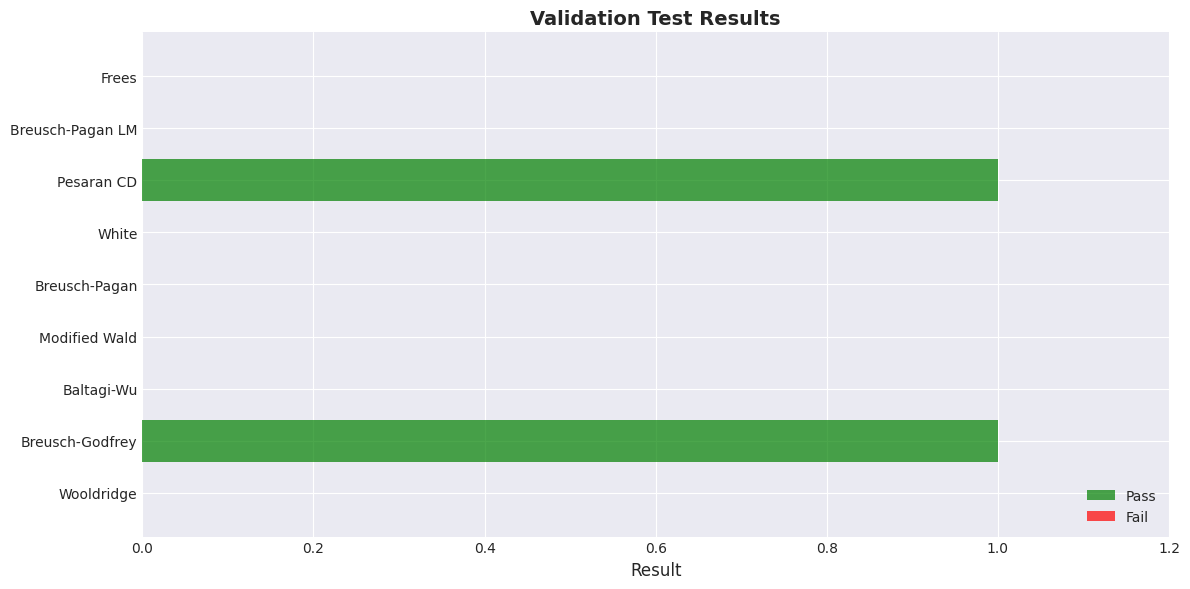


Green = Test passed
Red = Test failed (assumption violated)


In [25]:
# Plot validation results
fig, ax = plt.subplots(figsize=(12, 6))

# Collect all test results from report
all_tests = {}
if hasattr(report, 'specification_tests'):
    all_tests.update(report.specification_tests)
if hasattr(report, 'serial_tests'):
    all_tests.update(report.serial_tests)
if hasattr(report, 'het_tests'):
    all_tests.update(report.het_tests)
if hasattr(report, 'cd_tests'):
    all_tests.update(report.cd_tests)

# Extract test names and results
test_names = []
test_results = []
test_colors = []

for test_name, result in all_tests.items():
    test_names.append(test_name)
    passed = result.pvalue > 0.05  # Simplified
    test_results.append(1 if passed else 0)
    test_colors.append('green' if passed else 'red')

if test_names:  # Only plot if we have results
    # Create bar plot
    y_pos = np.arange(len(test_names))
    ax.barh(y_pos, test_results, color=test_colors, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(test_names)
    ax.set_xlabel('Result', fontsize=12)
    ax.set_title('Validation Test Results', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1.2])

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label='Pass'),
        Patch(facecolor='red', alpha=0.7, label='Fail')
    ]
    ax.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.show()

    print("\nGreen = Test passed")
    print("Red = Test failed (assumption violated)")
else:
    print("No test results to plot")

---

## 8. Remediation Guide {#remediation}

### Decision Tree: What to Do When Tests Fail

```
Test Failed → What to do?
│
├─ Hausman test failed
│  └→ Use Fixed Effects (not Random Effects)
│
├─ RESET test failed
│  └→ Add non-linear terms, interactions, or omitted variables
│
├─ Serial correlation detected
│  ├→ Use Driscoll-Kraay SE
│  ├→ Use Newey-West SE
│  └→ Or include lagged dependent variable (→ GMM)
│
├─ Heteroskedasticity detected
│  ├→ Use robust SE (HC0-HC3)
│  ├→ Use clustered SE
│  └→ Or use WLS (weighted least squares)
│
├─ Cross-sectional dependence
│  ├→ Use Driscoll-Kraay SE
│  ├→ Add common time effects
│  └→ Or use spatial econometrics models
│
├─ Unit root detected
│  ├→ First-difference the data
│  ├→ Test for cointegration
│  └→ If cointegrated → Error correction model
│
└─ No cointegration (but unit roots)
   └→ Use differenced data (avoid spurious regression)
```

### Quick Reference Table

| Problem | Solutions | PanelBox Implementation |
|---------|-----------|------------------------|
| **Serial Correlation** | Robust SE | `fit(cov_type='driscoll_kraay')` |
| | | `fit(cov_type='newey_west')` |
| **Heteroskedasticity** | Robust SE | `fit(cov_type='HC1')` |
| | Clustered SE | `fit(cov_type='clustered')` |
| **Cross-sectional Dep** | Driscoll-Kraay | `fit(cov_type='driscoll_kraay')` |
| **Unit Root** | First difference | Use `FirstDifferenceEstimator` |
| | GMM | Use `DifferenceGMM` or `SystemGMM` |
| **Non-stationarity** | Cointegration | ECM (coming soon) |

### Best Practices

1. ✅ **Always test**: Don't assume assumptions hold
2. ✅ **Test in order**: Specification → Diagnostics → Stationarity
3. ✅ **Use ValidationSuite**: Run all tests systematically
4. ✅ **Report tests**: Include in papers/reports
5. ✅ **Apply remediation**: Fix violations before making inference
6. ✅ **Re-test**: After remediation, test again

---

## Summary

You learned:

✅ **Specification Tests**: Hausman, RESET, Mundlak, Chow
✅ **Serial Correlation**: Wooldridge, Breusch-Godfrey, Baltagi-Wu
✅ **Heteroskedasticity**: Modified Wald, Breusch-Pagan, White
✅ **Cross-sectional Dependence**: Pesaran CD, BP-LM, Frees
✅ **Unit Root**: LLC, IPS, Fisher
✅ **Cointegration**: Pedroni, Kao
✅ **ValidationSuite**: Comprehensive testing framework
✅ **Remediation**: How to fix violations

### Key Takeaways

1. **Validation is not optional** - always test your assumptions
2. **ValidationSuite** makes it easy to run all tests at once
3. **Most violations can be fixed** with robust SE or model adjustments
4. **Report your tests** to increase credibility

### Next Steps

- **[04_robust_inference.ipynb](./04_robust_inference.ipynb)**: Deep dive into robust SE and bootstrap
- **[05_report_generation.ipynb](./05_report_generation.ipynb)**: Create publication-ready reports
- **[02_dynamic_gmm_complete.ipynb](./02_dynamic_gmm_complete.ipynb)**: If you have dynamics

---

*Validate with confidence using PanelBox!*